In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

Modularize the code into functions 

In [2]:
# Simulate S1 and S2
def simulate_S1_S2(num_points1, num_points2): 
    np.random.seed(26) # set random seed
    
    locations1 = np.random.rand(num_points1, 2) * 100
    locations2 = np.random.rand(num_points2, 2) * 200

    s1 = np.random.normal(50, 10, num_points1)  # Target support observations
    s2 = np.random.normal(100, 50, num_points2) # Source support observations

    return s1, locations1, s2, locations2

S1, loc1, S2, loc2 = simulate_S1_S2(100, 150)

# Simulate beta surface

def create_surface(locations):
    x = locations[:, 0]
    y = locations[:, 1]
    B = x + y  # True beta surface defined on target support S1
    return B

B = create_surface(loc1)

# Number of neighbors for smoothing (DGP-specific)
n_neighbor_dgp = 25

smoothed_S2_to_S1 = np.zeros(len(S1))

# Use KNN to smooth X values from S2 onto S1
nbrs_S2 = NearestNeighbors(n_neighbors=n_neighbor_dgp).fit(loc2)

for i in range(len(S1)):
    # Find neighbors of S1 location i in S2
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])

    # Aggregate the X values from S2 using a simple mean for the DGP (this is not the regression step)
    smoothed_S2_to_S1[i] = np.mean(S2[indices_S1_to_S2[0]])

y = B * smoothed_S2_to_S1  


In [3]:
def compute_aicc(n, rss, p):
    """
    Compute AIC corrected (AICc) for a linear regression model.
    
    Parameters:
    - n: number of observations
    - rss: residual sum of squares
    - p: number of parameters
    
    Returns:
    - AICc value
    """
    aic = n * np.log(rss / n) + 2 * p
    aicc = aic + (2 * p * (p + 1)) / (n - p - 1)
    return aicc

In [4]:
def perform_local_regression(n_neighbor_est, loc1, loc2, S2, y):
    
    recovered_betas = np.zeros(len(S1))
    residuals = np.zeros(len(S1))

    for i in range(len(S1)):
        local_X = []
        weights_X = []
        
        # Initialize Nearest Neighbors model to find neighbors in S2 for current S1_i
        nbrs_S2 = NearestNeighbors(n_neighbors=n_neighbor_est).fit(loc2)
        distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
        
        # Compute weights for the selected neighbors in S2 based on distance to S1_i
        for j, neighbor_index_S2 in enumerate(indices_S1_to_S2[0]):
            dist_j_to_i = distances_S1_to_S2[0][j]  # Distance from S2 neighbor j to S1 location i
            
            # Compute weight using a Gaussian kernel function
            weight = np.exp(-0.5 * (dist_j_to_i / 10)**2)
            
            # Collect S2 observation and its weight
            local_X.append(S2[neighbor_index_S2])
            weights_X.append(weight)
        
        # Convert lists to numpy arrays for further processing
        local_X = np.array(local_X)
        weights_X = np.array(weights_X)

        # Apply the computed weights to the selected S2 observations (X values)
        # This effectively smooths the S2 observations towards S1_i
        weighted_X_i = np.sum(local_X * weights_X) / np.sum(weights_X)

        # Perform local regression using the weighted S2 data at S1_i
        # Initialize Nearest Neighbors model to find neighbors in S1 for current S1_i
        nbrs_S1 = NearestNeighbors(n_neighbors=n_neighbor_est).fit(loc1)
        distances, indices = nbrs_S1.kneighbors([loc1[i]])

        # Obtain y values of neighbors in S1
        y_neighbors = y[indices[0]]
        
        # Use the same weighted X value for all neighbors
        X_neighbors = weighted_X_i * np.ones(len(indices[0]))

        # Compute regression weights based on distances between neighbors in S1
        weights_y = np.exp(-0.5 * (distances[0] / 10)**2)  # Gaussian kernel
        W_y = np.sqrt(weights_y)

        # Prepare weighted datasets for local regression
        X_weighted = (X_neighbors * W_y).reshape(-1, 1)
        y_weighted = y_neighbors * W_y

        # Fit weighted linear regression
        model = LinearRegression(fit_intercept=True)
        model.fit(X_weighted, y_weighted)

        # predict and calculate residuals for AIC
        y_pred = model.predict(X_weighted)
        residuals[i] = np.sum((y_weighted - y_pred)**2)

        # Store recovered beta
        recovered_beta = model.coef_[0]
        recovered_betas[i] = recovered_beta
    
    rss = np.sum(residuals)
    n = len(S1)
    p = 2  # Two parameters: intercept and slope

    aicc = compute_aicc(n, rss, p)
    
    return recovered_betas, aicc



Optimal k: 3, with AIC: 1270.9710
 
 
All k values and their AICcs:>>>
{3: 1270.9709683046915, 6: 1447.1408811256517, 9: 1521.2722639560711, 12: 1553.7298178700491, 15: 1573.908083387761, 18: 1587.0999839664466, 21: 1594.825742860077, 24: 1601.5483221185882, 27: 1605.7981530891784}
 
 


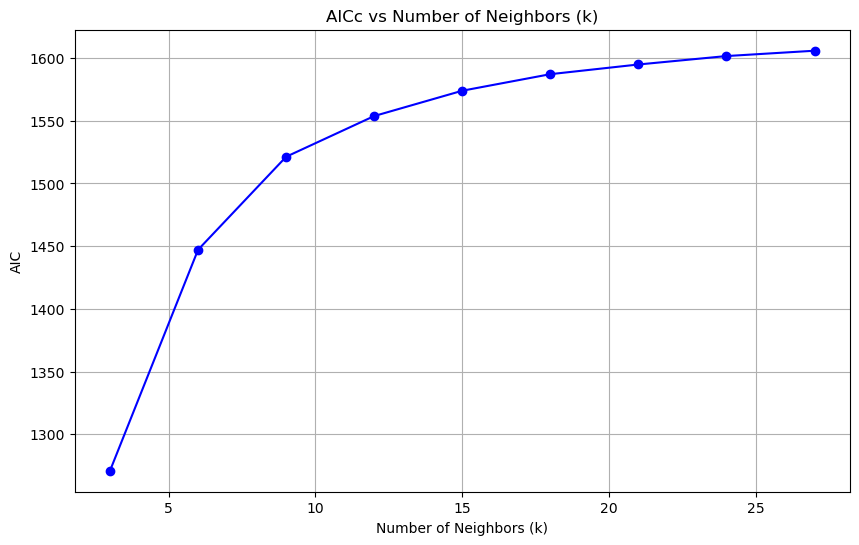

In [5]:
def find_optimal_k(k_values, loc1, loc2, S2, y):
    optimal_k = None
    lowest_aicc = float('inf')
    results = {}
    betas_dict = {}  # To store recovered betas for each k

    for k in k_values:
        recovered_betas, aicc = perform_local_regression(n_neighbor_est=k, loc1=loc1, loc2=loc2, S2=S2, y=y)
        results[k] = aicc
        betas_dict[k] = recovered_betas  # Store recovered betas for plotting

        if aicc < lowest_aicc:
            lowest_aicc = aicc
            optimal_k = k
    return optimal_k, lowest_aicc, results, betas_dict


# Define the range of k values to search
k_values = list(range(3, 30, 3))  # Test k = 2, 4, 6, 8, ..., 20

# Find the optimal k using AIC
optimal_k, lowest_aicc, results, betas_dict = find_optimal_k(k_values, loc1, loc2, S2, y)

print(f"Optimal k: {optimal_k}, with AIC: {lowest_aicc:.4f}")
print(" ")
print(" ")

print("All k values and their AICcs:>>>")
print(results)
print(" ")
print(" ")

# Plotting AICc vs k
plt.figure(figsize=(10, 6))
plt.plot(k_values, [results[k] for k in k_values], marker='o', linestyle='-', color='b')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('AIC')
plt.title('AICc vs Number of Neighbors (k)')
plt.grid(True)
plt.show()

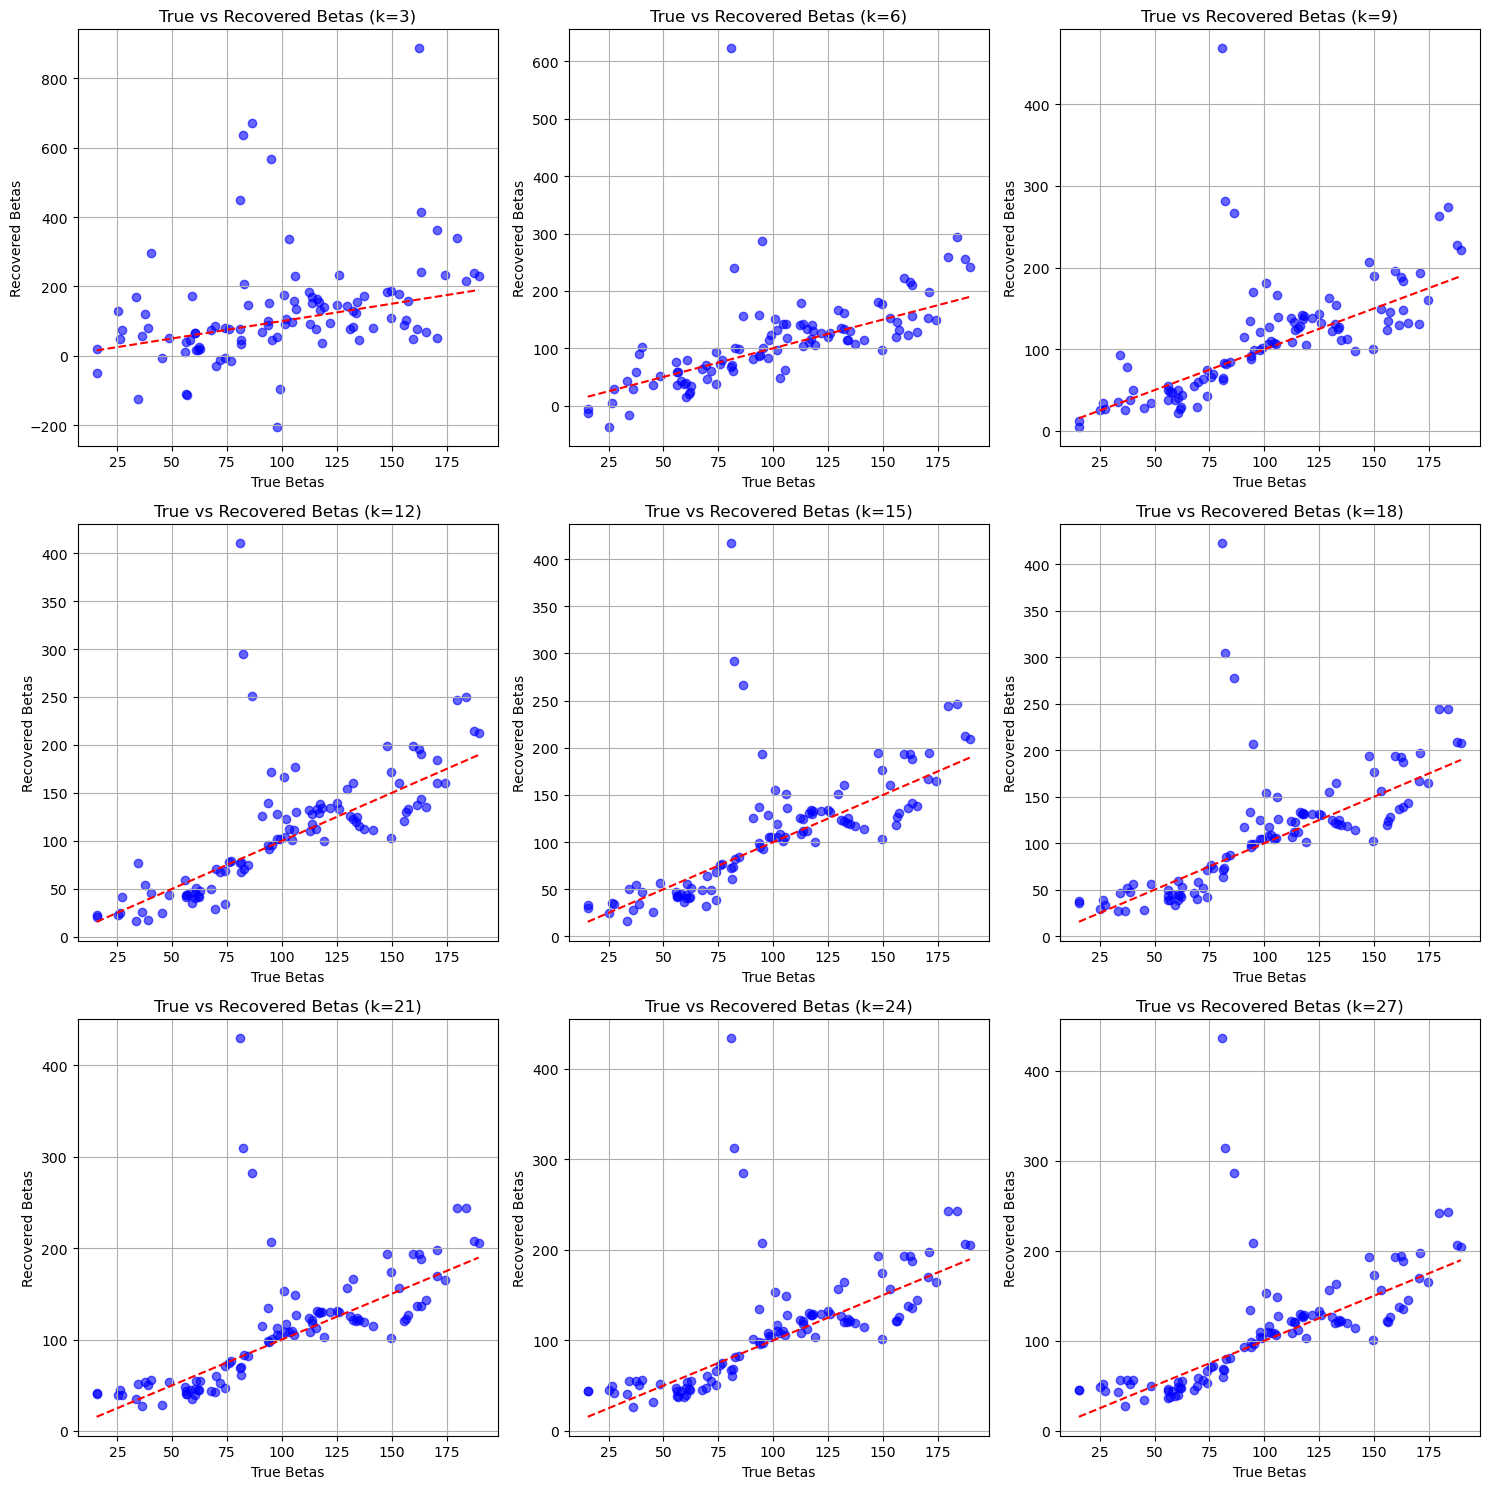

In [6]:
# Plotting True Betas vs Recovered Betas for Different ks

n_plots = len(k_values)
n_cols = 3  # Number of columns for subplots
n_rows = (n_plots + n_cols - 1) // n_cols  # Compute number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flatten the axes array for easier iteration

for idx, k in enumerate(k_values):
    ax = axes[idx]
    ax.scatter(B, betas_dict[k], color='blue', alpha=0.6)
    ax.plot([min(B), max(B)], [min(B), max(B)], color='red', linestyle='--')
    ax.set_xlabel('True Betas')
    ax.set_ylabel('Recovered Betas')
    ax.set_title(f'True vs Recovered Betas (k={k})')
    ax.grid(True)

# Hide any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

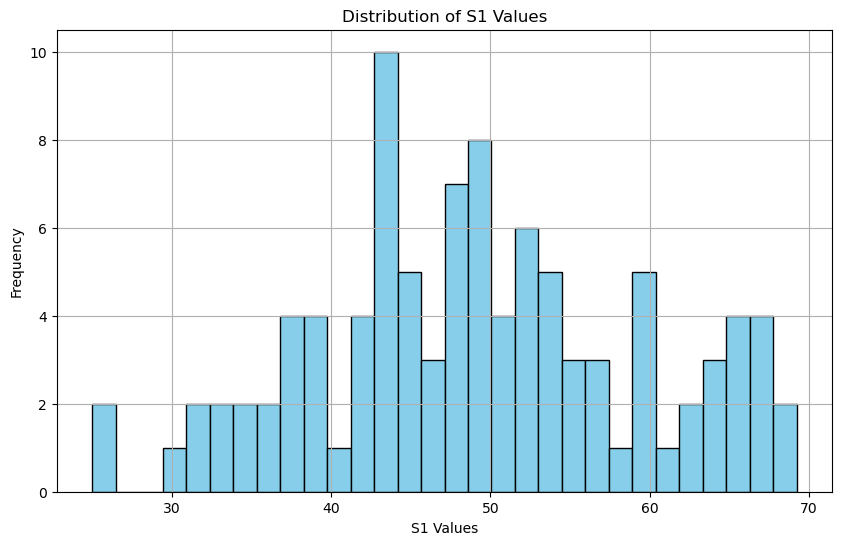

In [7]:
# Visualize the distribution of S1
plt.figure(figsize=(10, 6))
plt.hist(S1, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('S1 Values')
plt.ylabel('Frequency')
plt.title('Distribution of S1 Values')
plt.grid(True)
plt.show()

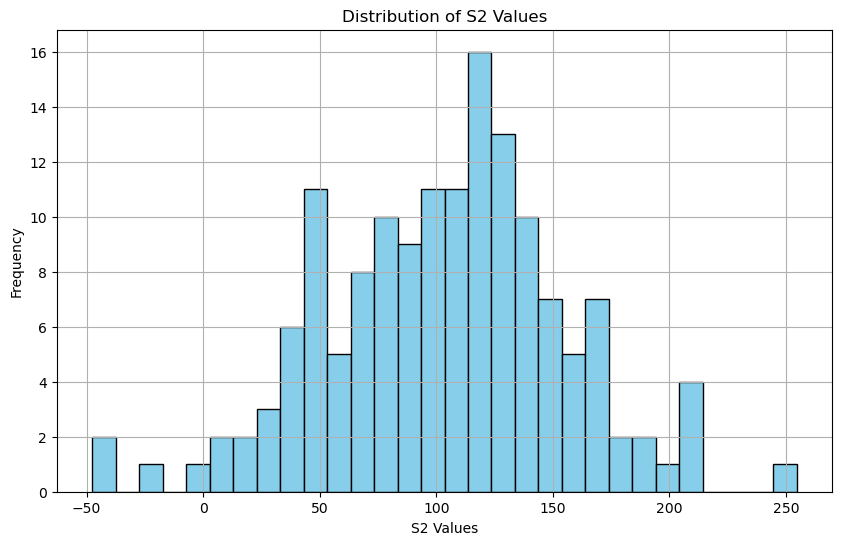

In [8]:
# Visualize the distribution of S2
plt.figure(figsize=(10, 6))
plt.hist(S2, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('S2 Values')
plt.ylabel('Frequency')
plt.title('Distribution of S2 Values')
plt.grid(True)
plt.show()

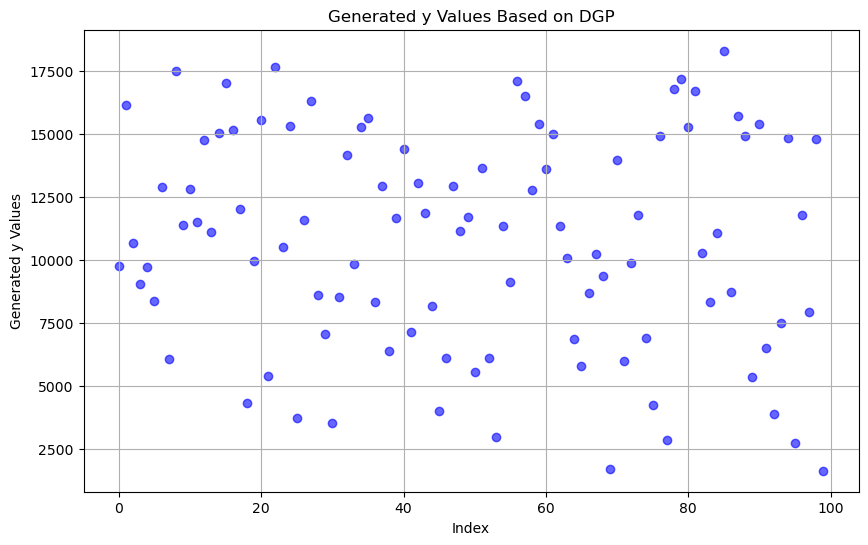

In [9]:
# Visualize generated y values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y)), y, color='blue', alpha=0.6)
plt.xlabel('Index')
plt.ylabel('Generated y Values')
plt.title('Generated y Values Based on DGP')
plt.grid(True)
plt.show()

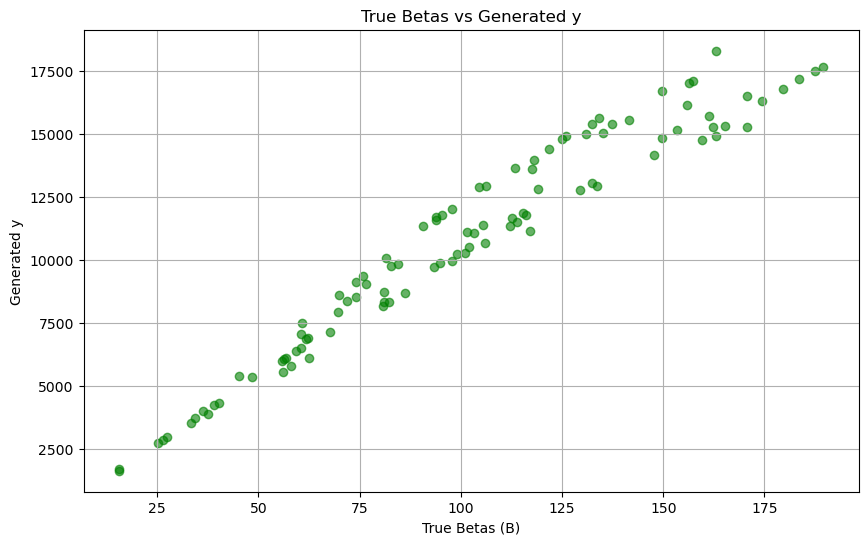

In [10]:
# Compare True Betas B with Generated y
plt.figure(figsize=(10, 6))
plt.scatter(B, y, color='green', alpha=0.6)
plt.xlabel('True Betas (B)')
plt.ylabel('Generated y')
plt.title('True Betas vs Generated y')
plt.grid(True)
plt.show()

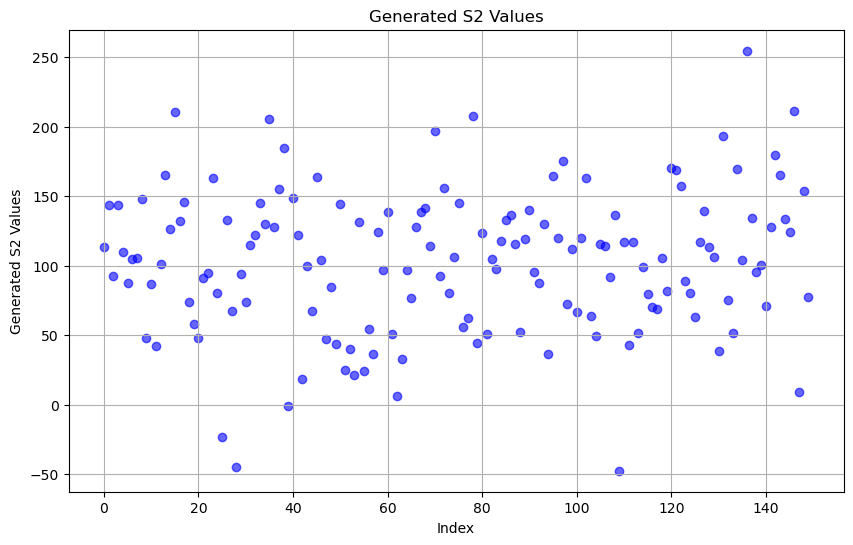

In [11]:
# Visualize generated S2 values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(S2)), S2, color='blue', alpha=0.6)
plt.xlabel('Index')
plt.ylabel('Generated S2 Values')
plt.title('Generated S2 Values')
plt.grid(True)
plt.show()

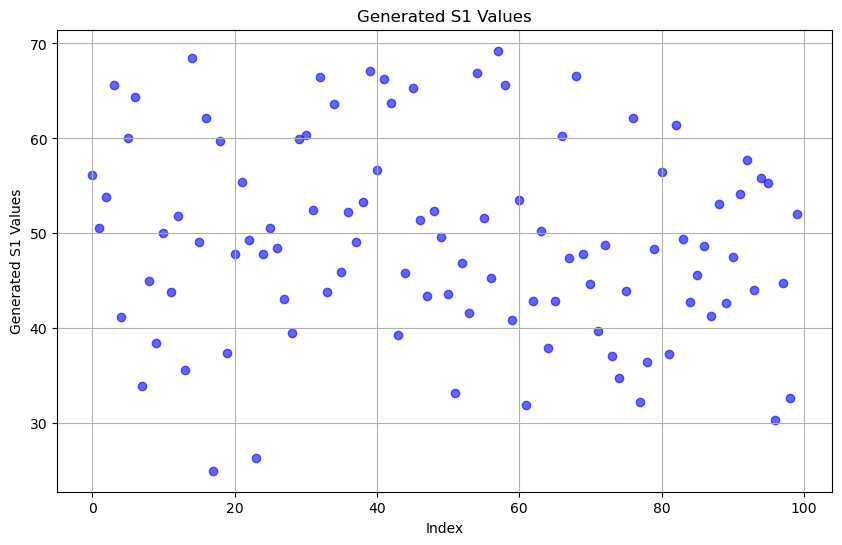

In [12]:
# Visualize generated S1 values

plt.figure(figsize=(10, 6))
plt.scatter(range(len(S1)), S1, color='blue', alpha=0.6)
plt.xlabel('Index')
plt.ylabel('Generated S1 Values')
plt.title('Generated S1 Values')
plt.grid(True)
plt.show()

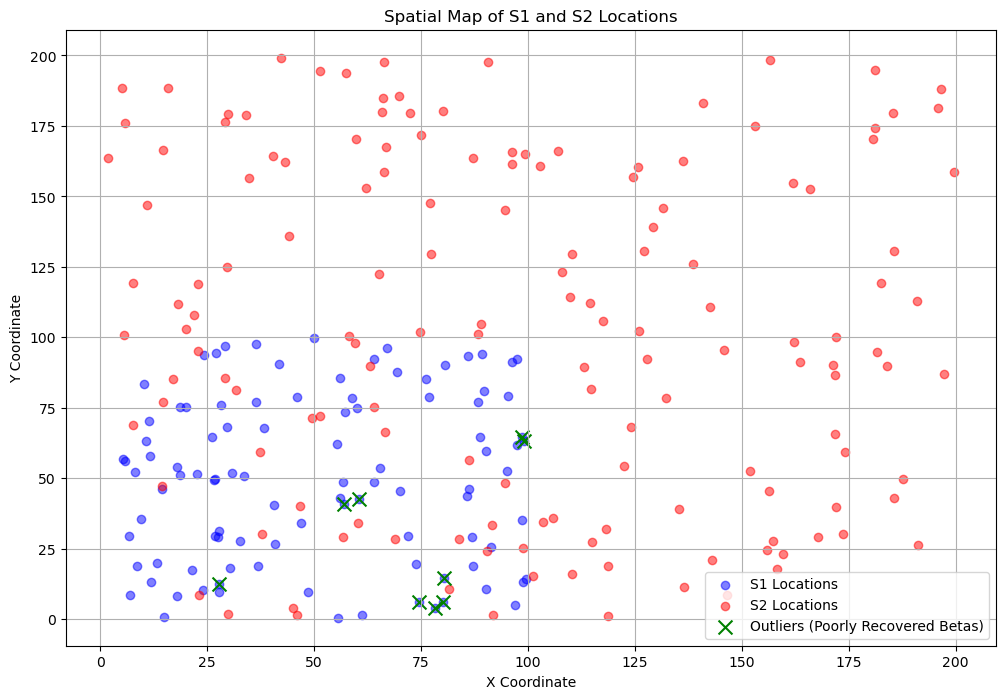

In [13]:
# Choose the optimal k based on AICc
optimal_k = optimal_k  

# Calculate absolute differences between true and recovered betas for the optimal k
differences_optimal_k = np.abs(B - betas_dict[optimal_k])

threshold = 200  # Threshold for identifying poorly recovered betas 
                # (I used 200 becuase points above 200 seem to deviate more significantly from the dashed line)

outlier_indices = np.where(differences_optimal_k > threshold)[0]  # Indices where difference is greater than threshold

# Visualize S1 and S2 on a map
plt.figure(figsize=(12, 8))

# Plot S1 locations
plt.scatter(loc1[:, 0], loc1[:, 1], color='blue', alpha=0.5, label='S1 Locations')

# Plot S2 locations
plt.scatter(loc2[:, 0], loc2[:, 1], color='red', alpha=0.5, label='S2 Locations')

# Highlight the outliers in S1
if len(outlier_indices) > 0:
    plt.scatter(loc1[outlier_indices, 0], loc1[outlier_indices, 1], color='green', 
                 s=100, label='Outliers (Poorly Recovered Betas)', marker='x')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f'Spatial Map of S1 and S2 Locations')
plt.legend()
plt.grid(True)
plt.show()
